In [15]:
# Importanmos librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

🐝 **Explicación simple de las métricas (sin miedo a sonar básica)**

Piensa que cada cliente es una persona usando su tarjeta / producto.

👾 **Frecuencia (frecuencia_tx)**

Qué es: cuántas transacciones hizo el cliente en el periodo analizado.

Intuición: entre más veces usa el producto, más “enganchado” está.

> Ejemplo:

> * Cliente A: 2 transacciones → baja frecuencia.

> * Cliente B: 80 transacciones → alta frecuencia.

👾 **Monetario (monto_total)**

Qué es: la suma del valor de todas las transacciones del cliente.

Intuición: cuánto dinero “mueve” ese cliente para el negocio.

> Ejemplo:

> * Cliente A: total de $300.000 → bajo monto.

> * Cliente B: total de $45.000.000 → altísimo valor para el portafolio.

👾 **Recencia (recencia_dias)**

Qué es: cuántos días han pasado desde la última transacción del cliente hasta la fecha máxima del periodo.

Fórmula conceptual:
recencia_dias = (fecha_ref - ultima_fecha_cliente)
donde fecha_ref es la fecha más reciente en el dataset (ej: 2021-03-08).

Intuición:

Pocos días → cliente activo recientemente.

Muchos días → cliente dormido / inactivo.

> Ejemplo:

> * Cliente A hizo su última compra hace 3 días → recencia_dias = 3.

> * Cliente B hizo su última compra hace 120 días → recencia_dias = 120.

👾 **RFM (Recency, Frequency, Monetary)**

Es una forma clásica de segmentar clientes usada en retail, banca, ecommerce.

> R (Recency): qué tan reciente fue la última compra.

> * Menos días = mejor (más activo).

> F (Frequency): cuántas veces compra.

> * Más transacciones = mejor.

> M (Monetary): cuánto dinero gasta.

> * Más monto = mejor.

Lo típico es convertir cada métrica a un score de 1 a 5:

1 = malo / bajo / lejos.

5 = muy bueno / alto / cercano.

> Por ejemplo:

> * R_score = 5 → cliente compró hace muy poco.

> * F_score = 5 → cliente compra muchas veces.

> * M_score = 5 → cliente gasta bastante.

Y se puede armar un código RFM tipo:

>>Cliente con RFM = 555 → súper top: compra mucho, seguido y hace poco.

>>Cliente con RFM = 155 → compró hace mucho (R=1) pero cuando compra, gasta bastante y con frecuencia.

>>Cliente con RFM = 511 → compró hace muy poco, pero poco monto y poca frecuencia.

#### En el código, vamos a calcular:

#### R_score, F_score, M_score

#### RFM_score_str (ej: "545")

#### RFM_score_sum (ej: 5+4+5 = 14)

codigo con graficos 



1. CARGA DE DATOS
>> Detalle_cliente - primeras filas:
 Id_cliente  fecha_efectiva  Id_tx
        136      20210303.0   6869
        116      20201129.0   4355
        119      20200929.0   5416
        121      20210222.0   3249
        152      20200930.0   2774

>> Detalle_tx - primeras filas:
 Id_tx  clase   valor
  6869 COMPRA 3495240
  4355 COMPRA  475800
  5416 COMPRA  115775
  3249 COMPRA 1579898
  2774 COMPRA   84077

>> Columnas Detalle_cliente: ['Id_cliente', 'fecha_efectiva', 'Id_tx']
>> Columnas Detalle_tx: ['Id_tx', 'clase', 'valor']

>> Info Detalle_cliente:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id_cliente      2500 non-null   int64  
 1   fecha_efectiva  2488 non-null   float64
 2   Id_tx           2500 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 58.7 KB
None

>> Info Detalle_tx:
<class 'pan

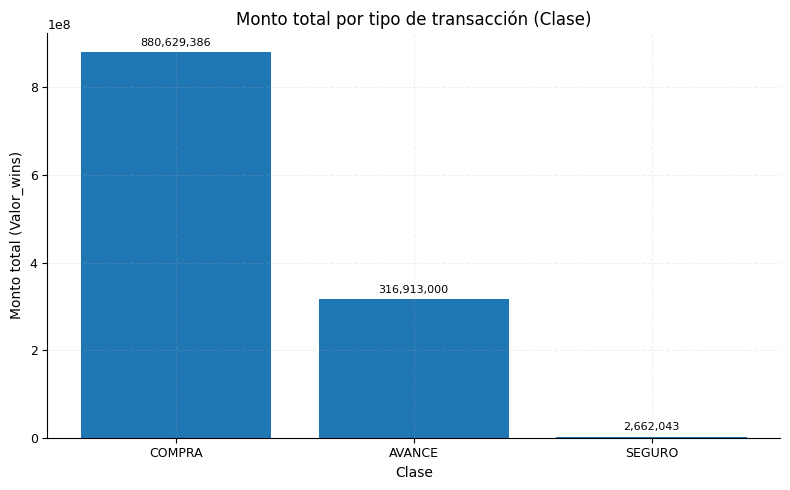

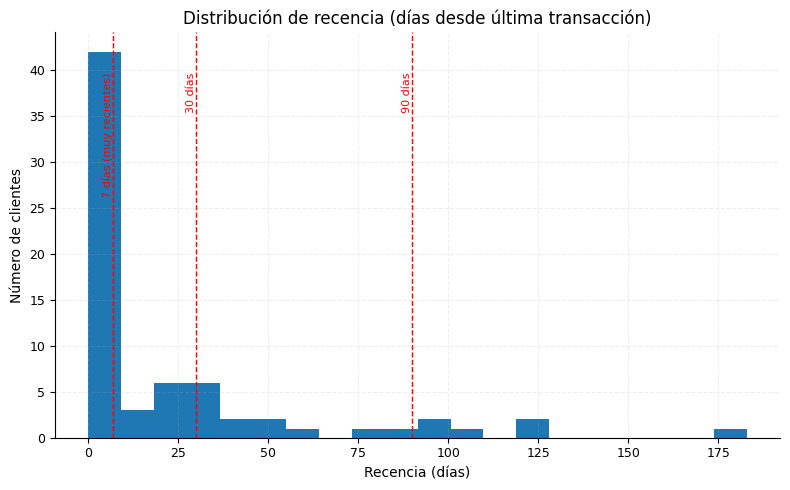

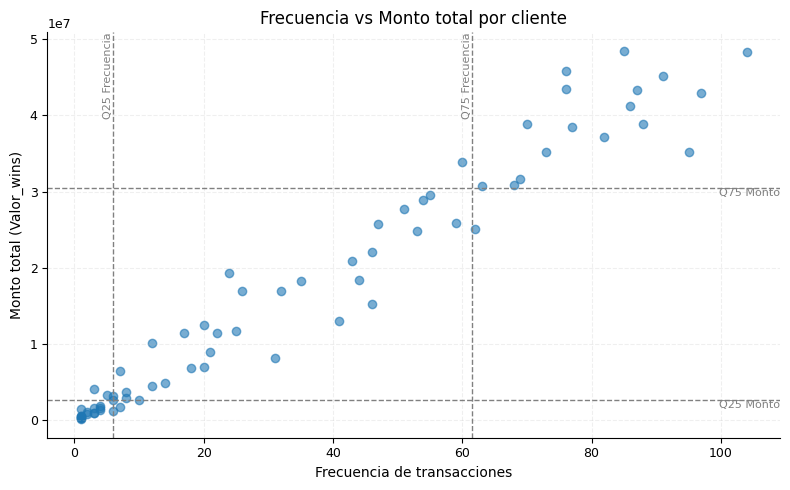

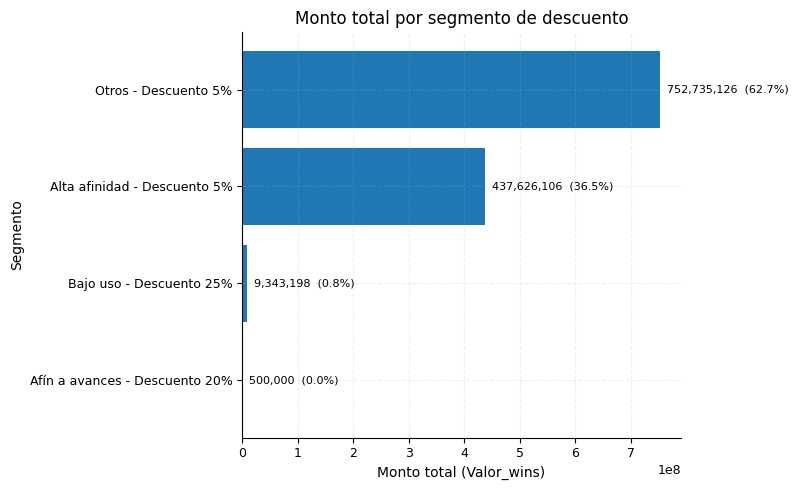

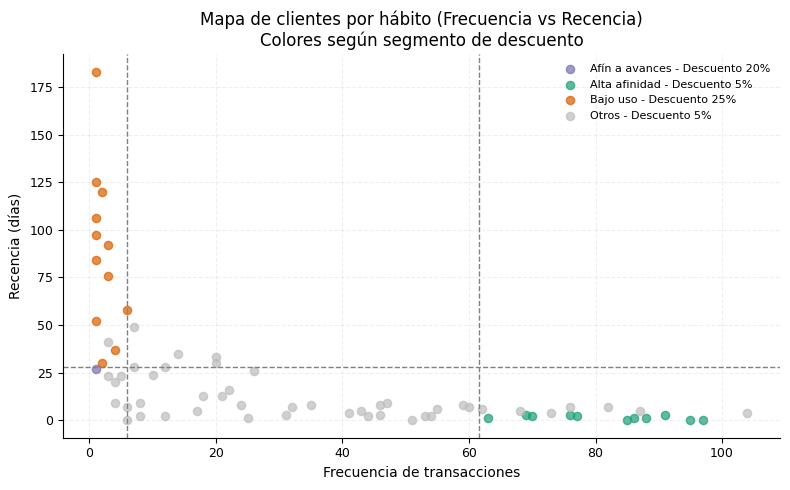

>> Reporte PDF generado: reporte_portafolio.pdf


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ==========================
# UTILIDADES GENERALES
# ==========================

def print_seccion(titulo: str):
    print("\n" + "="*80)
    print(titulo.upper())
    print("="*80)

def set_estilo_minimalista():
    """
    - Fondo blanco
    - Pocas líneas
    - Spines superiores/derechos ocultos
    - Grid suave en eje principal
    - Fuente consistente
    """
    plt.rcParams.update({
        "figure.figsize": (8, 5),
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.2,
        "grid.linestyle": "--",
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "figure.autolayout": True,
    })

# ==========================
# 1. CARGA DE DATOS
# ==========================

def cargar_datos(
    ruta_archivo: str,
    tipo_archivo: str = "excel"
):
    """
    Carga las tablas Detalle_cliente y Detalle_tx desde UN SOLO archivo Excel.
    Se espera que existan dos hojas:
      - 'Detalle_cliente': Id_cliente, fecha_efectiva, Id_tx
      - 'Detalle_tx': Id_tx, clase, valor
    """
    print_seccion("1. CARGA DE DATOS")

    if tipo_archivo == "excel":
        xls = pd.ExcelFile(ruta_archivo)
        df_clientes = pd.read_excel(xls, sheet_name="Detalle_cliente")
        df_tx = pd.read_excel(xls, sheet_name="Detalle_tx")
    else:
        raise ValueError("tipo_archivo debe ser 'excel'.")

    print(">> Detalle_cliente - primeras filas:")
    print(df_clientes.head().to_string(index=False))

    print("\n>> Detalle_tx - primeras filas:")
    print(df_tx.head().to_string(index=False))

    print("\n>> Columnas Detalle_cliente:", list(df_clientes.columns))
    print(">> Columnas Detalle_tx:", list(df_tx.columns))

    print("\n>> Info Detalle_cliente:")
    print(df_clientes.info())

    print("\n>> Info Detalle_tx:")
    print(df_tx.info())

    return df_clientes, df_tx

# ==========================
# 2. PREPROCESAMIENTO
# ==========================

def preprocesar_datos(df_clientes: pd.DataFrame, df_tx: pd.DataFrame):
    """
    Limpieza básica, tipos de datos, join, manejo de outliers y enriquecimiento de fechas.

    Puntos clave:
    - Convertimos fecha_efectiva (numérica YYYYMMDD.0) a datetime real.
    - Aseguramos Id_cliente y Id_tx como string (identificadores).
    - Convertimos valor a numérico.
    - Hacemos un winsorizing (1%-99%) para suavizar outliers en Valor.
    - Unimos Detalle_cliente y Detalle_tx por Id_tx.
    - Creamos columnas de año, mes, día y día_semana.
    """
    print_seccion("2. PREPROCESAMIENTO")

    # --- Normalizar nombres de columnas a una forma estándar
    df_clientes = df_clientes.rename(columns={
        "Id_cliente": "Id_cliente",
        "fecha_efectiva": "Fecha_efectiva",
        "Id_tx": "Id_tx"
    })

    df_tx = df_tx.rename(columns={
        "Id_tx": "Id_tx",
        "clase": "Clase",
        "valor": "Valor"
    })

    print(">> Columnas después del rename - Detalle_cliente:", list(df_clientes.columns))
    print(">> Columnas después del rename - Detalle_tx:", list(df_tx.columns))

    # --- Conversión de tipos de datos
    print("\n>> Conversión de tipos de datos")

    # Fecha_efectiva viene como número tipo 20210303.0 -> convertir a fecha real
    df_clientes["Fecha_efectiva"] = pd.to_datetime(
        df_clientes["Fecha_efectiva"]
        .astype("Int64")    # quita decimales tipo .0
        .astype(str),       # pásalo a string
        format="%Y%m%d",
        errors="coerce"
    )

    # Id_cliente e Id_tx como string
    df_clientes["Id_cliente"] = df_clientes["Id_cliente"].astype(str)
    df_clientes["Id_tx"] = df_clientes["Id_tx"].astype(str)
    df_tx["Id_tx"] = df_tx["Id_tx"].astype(str)

    # Valor a numérico
    df_tx["Valor"] = pd.to_numeric(df_tx["Valor"], errors="coerce")

    # --- Nulos
    print("\n>> Nulos por columna - Detalle_cliente:")
    print(df_clientes.isna().sum())

    print("\n>> Nulos por columna - Detalle_tx:")
    print(df_tx.isna().sum())

    # Limpiar básicos
    df_clientes = df_clientes.dropna(subset=["Id_cliente", "Fecha_efectiva", "Id_tx"])
    df_tx = df_tx.dropna(subset=["Id_tx", "Clase", "Valor"])

    # --- Outliers en Valor (winsorizing)
    q01 = df_tx["Valor"].quantile(0.01)
    q99 = df_tx["Valor"].quantile(0.99)
    print(f"\n>> Rango de Valor antes de winsorizar: min={df_tx['Valor'].min()}, max={df_tx['Valor'].max()}")
    df_tx["Valor_wins"] = df_tx["Valor"].clip(lower=q01, upper=q99)
    print(f">> Rango de Valor_wins después de winsorizar: min={df_tx['Valor_wins'].min()}, max={df_tx['Valor_wins'].max()}")

    # --- Revisar duplicados en Id_tx (Detalle_tx)
    print("\n>> Revisión de duplicados en Id_tx de Detalle_tx")
    dup_tx = df_tx[df_tx["Id_tx"].duplicated(keep=False)].sort_values("Id_tx")
    n_dup_ids = dup_tx["Id_tx"].nunique()
    print(f">> Número de Id_tx que aparecen más de una vez en Detalle_tx: {n_dup_ids}")
    if not dup_tx.empty:
        print(">> Ejemplo de filas con Id_tx duplicados (máx 10):")
        print(dup_tx.head(10).to_string(index=False))
        print(">> NOTA: El join será many-to-many para estos Id_tx, se replicarán filas.")

    # --- Join entre tablas (left join desde Detalle_cliente usando Id_tx)
    print("\n>> Realizando JOIN entre Detalle_cliente y Detalle_tx por Id_tx (many-to-many permitido)")
    df = df_clientes.merge(
        df_tx,
        how="left",
        on="Id_tx"   # SIN validate para permitir m:m
    )

    print(">> Primeras filas después del JOIN:")
    print(df.head().to_string(index=False))

    # --- Enriquecimiento de fechas
    print("\n>> Enriquecimiento de columnas de fecha")
    df["anio"] = df["Fecha_efectiva"].dt.year
    df["mes"] = df["Fecha_efectiva"].dt.month
    df["dia"] = df["Fecha_efectiva"].dt.day
    df["dia_semana"] = df["Fecha_efectiva"].dt.day_name()

    print(df[["Fecha_efectiva", "anio", "mes", "dia", "dia_semana"]].head().to_string(index=False))

    return df

# ==========================
# 3. ANALISIS DESCRIPTIVO
# ==========================

def analisis_descriptivo(df: pd.DataFrame):
    """
    Análisis descriptivo básico:
    - Rango de fechas (periodo analizado)
    - Nº de clientes y transacciones
    - Distribución y montos por Clase
    - Frecuencia por cliente
    - Ticket promedio por cliente
    - Recencia (días desde la última transacción)
    - Concentración de facturación en Top clientes
    """
    print_seccion("3. ANALISIS DESCRIPTIVO")

    print(">> Dimensiones del dataset completo (post-join):", df.shape)
    print(">> Rango de fechas observado:")
    print("   Fecha mínima:", df["Fecha_efectiva"].min())
    print("   Fecha máxima:", df["Fecha_efectiva"].max())

    n_clientes = df["Id_cliente"].nunique()
    n_transacciones = df["Id_tx"].nunique()
    print(f"\n>> Número de clientes únicos: {n_clientes}")
    print(f">> Número de transacciones únicas (Id_tx): {n_transacciones}")

    print("\n>> Distribución de transacciones por Clase:")
    print(df["Clase"].value_counts(dropna=False))

    print("\n>> Monto total por Clase (usando Valor_wins):")
    print(
        df.groupby("Clase")["Valor_wins"]
        .agg(["count", "sum", "mean"])
        .rename(columns={"count": "n_tx", "sum": "monto_total", "mean": "ticket_promedio"})
        .round(2)
        .to_string()
    )

    freq_cliente = (
        df.groupby("Id_cliente")["Id_tx"]
        .nunique()
        .rename("frecuencia_tx")
    )
    print("\n>> Estadísticos de frecuencia de transacciones por cliente:")
    print(freq_cliente.describe().round(2).to_string())

    ticket_promedio_cliente = (
        df.groupby("Id_cliente")["Valor_wins"]
        .mean()
        .rename("ticket_promedio_cliente")
    )
    print("\n>> Estadísticos de ticket promedio por cliente:")
    print(ticket_promedio_cliente.describe().round(2).to_string())

    fecha_ref = df["Fecha_efectiva"].max()
    recencia = (
        df.groupby("Id_cliente")["Fecha_efectiva"]
        .max()
        .rename("ultima_fecha")
        .to_frame()
    )
    recencia["recencia_dias"] = (fecha_ref - recencia["ultima_fecha"]).dt.days

    print("\n>> Estadísticos de recencia (días desde la última transacción):")
    print(recencia["recencia_dias"].describe().round(2).to_string())

    monto_por_cliente = (
        df.groupby("Id_cliente")["Valor_wins"]
        .sum()
        .rename("monto_total_cliente")
    )
    top10 = monto_por_cliente.sort_values(ascending=False).head(10)
    contrib_top10 = top10.sum() / monto_por_cliente.sum()

    print("\n>> Top 10 clientes por monto y su contribución a la facturación total:")
    print(top10.round(2).to_string())
    print(f">> Porcentaje del monto total concentrado en top 10 clientes: {contrib_top10:.2%}")

    return {
        "freq_cliente": freq_cliente,
        "ticket_promedio_cliente": ticket_promedio_cliente,
        "recencia": recencia,
        "monto_por_cliente": monto_por_cliente,
        "fecha_ref": fecha_ref
    }

# ==========================
# 4. FEATURES A NIVEL CLIENTE (INCLUYE R, F, M)
# ==========================

def construir_features_cliente(df: pd.DataFrame, analisis_dict: dict):
    """
    Construye una tabla a nivel cliente con:
    - frecuencia_tx (F de RFM)
    - monto_total (M de RFM)
    - recencia_dias (R de RFM)
    - indicadores de compras y avances
    - proporción de compras y avances
    - ticket_promedio
    """
    print_seccion("4. CONSTRUCCION DE FEATURES A NIVEL CLIENTE")

    df["es_compra"] = (df["Clase"].astype(str).str.upper().str.contains("COMPRA")).astype(int)
    df["es_avance"] = (df["Clase"].astype(str).str.upper().str.contains("AVANCE")).astype(int)

    df["monto_compra"] = np.where(df["es_compra"] == 1, df["Valor_wins"], 0.0)
    df["monto_avance"] = np.where(df["es_avance"] == 1, df["Valor_wins"], 0.0)

    agg_cliente = df.groupby("Id_cliente").agg(
        frecuencia_tx=("Id_tx", "nunique"),
        monto_total=("Valor_wins", "sum"),
        n_compras=("es_compra", "sum"),
        n_avances=("es_avance", "sum"),
        monto_compras=("monto_compra", "sum"),
        monto_avances=("monto_avance", "sum"),
        ultima_fecha=("Fecha_efectiva", "max")
    )

    # Recencia: días desde la última transacción hasta la fecha máxima del dataset
    fecha_ref = analisis_dict["fecha_ref"]
    agg_cliente["recencia_dias"] = (fecha_ref - agg_cliente["ultima_fecha"]).dt.days

    # Proporción de compras y avances
    agg_cliente["total_ops_tipo"] = agg_cliente["n_compras"] + agg_cliente["n_avances"]
    agg_cliente["prop_compras"] = np.where(
        agg_cliente["total_ops_tipo"] > 0,
        agg_cliente["n_compras"] / agg_cliente["total_ops_tipo"],
        0.0
    )
    agg_cliente["prop_avances"] = np.where(
        agg_cliente["total_ops_tipo"] > 0,
        agg_cliente["n_avances"] / agg_cliente["total_ops_tipo"],
        0.0
    )

    # Ticket promedio
    agg_cliente["ticket_promedio"] = np.where(
        agg_cliente["frecuencia_tx"] > 0,
        agg_cliente["monto_total"] / agg_cliente["frecuencia_tx"],
        0.0
    )

    print(">> Primeras filas de la tabla de features a nivel cliente:")
    print(agg_cliente.head().round(2).to_string())

    return agg_cliente

# ==========================
# 4b. RFM SCORING
# ==========================

def _score_por_cuantiles(serie: pd.Series, reverse: bool = False):
    """
    Asigna un score de 1 a 5 según cuantiles.
    - reverse=False: valores bajos -> score bajo (1), valores altos -> score alto (5)
    - reverse=True: valores bajos -> score alto (5), valores altos -> score bajo (1)
      (útil para Recency, donde menos días = mejor)
    """
    q = serie.quantile([0.2, 0.4, 0.6, 0.8]).values

    def _score(x):
        if pd.isna(x):
            return np.nan
        if not reverse:
            # bajo a alto
            if x <= q[0]:
                return 1
            elif x <= q[1]:
                return 2
            elif x <= q[2]:
                return 3
            elif x <= q[3]:
                return 4
            else:
                return 5
        else:
            # invertido (para recencia: pocos días = 5)
            if x <= q[0]:
                return 5
            elif x <= q[1]:
                return 4
            elif x <= q[2]:
                return 3
            elif x <= q[3]:
                return 2
            else:
                return 1

    return serie.apply(_score)

def construir_rfm_scores(agg_cliente: pd.DataFrame):
    """
    A partir de la tabla a nivel cliente, calcula:
    - R_score (1-5) a partir de recencia_dias (menos días = mejor)
    - F_score (1-5) a partir de frecuencia_tx (más frecuencias = mejor)
    - M_score (1-5) a partir de monto_total (más monto = mejor)
    - RFM_score_str = concatenación tipo '545'
    - RFM_score_sum = suma de scores (máx 15, mínimo 3)
    """
    print_seccion("4b. RFM SCORING (RECENCY, FREQUENCY, MONETARY)")

    agg_cliente = agg_cliente.copy()

    agg_cliente["R_score"] = _score_por_cuantiles(agg_cliente["recencia_dias"], reverse=True)
    agg_cliente["F_score"] = _score_por_cuantiles(agg_cliente["frecuencia_tx"], reverse=False)
    agg_cliente["M_score"] = _score_por_cuantiles(agg_cliente["monto_total"], reverse=False)

    agg_cliente["RFM_score_str"] = (
        agg_cliente["R_score"].astype("Int64").astype(str)
        + agg_cliente["F_score"].astype("Int64").astype(str)
        + agg_cliente["M_score"].astype("Int64").astype(str)
    )
    agg_cliente["RFM_score_sum"] = (
        agg_cliente["R_score"] + agg_cliente["F_score"] + agg_cliente["M_score"]
    )

    print(">> Ejemplo de RFM por cliente:")
    print(
        agg_cliente[[
            "frecuencia_tx", "monto_total", "recencia_dias",
            "R_score", "F_score", "M_score", "RFM_score_str", "RFM_score_sum"
        ]].head().round(2).to_string()
    )

    print("\n>> Distribución de RFM_score_sum (3 = bajo, 15 = muy alto):")
    print(agg_cliente["RFM_score_sum"].describe().round(2).to_string())

    return agg_cliente

# ==========================
# 5. SEGMENTACION Y ESTRATEGIA DE DESCUENTOS
# ==========================

def segmentar_clientes(agg_cliente: pd.DataFrame):
    """
    Segmentación basada en reglas de negocio + cuantiles:

    - 'Bajo uso - Descuento 25%':
        poca frecuencia, poco monto y recencia alta (clientes lejanos, poco valor actual).
    - 'Afín a avances - Descuento 20%':
        alta proporción de avances (>=50%), pocas compras.
    - 'Alta afinidad - Descuento 5%':
        alta frecuencia, alto monto, recencia baja, y fuerte peso en compras.
    - 'Otros - Descuento 5%':
        resto de clientes, que se podría refinar con más tiempo/modelos.
    """
    print_seccion("5. SEGMENTACION DE CLIENTES Y DESCUENTOS")

    q_freq = agg_cliente["frecuencia_tx"].quantile([0.25, 0.75])
    q_monto = agg_cliente["monto_total"].quantile([0.25, 0.75])
    q_rec = agg_cliente["recencia_dias"].quantile([0.25, 0.75])
    q_n_compras = agg_cliente["n_compras"].quantile([0.25, 0.75])

    print(">> Cuantiles de referencia para reglas:")
    print("   Frecuencia_tx (25%, 75%):", q_freq.to_dict())
    print("   Monto_total (25%, 75%):", q_monto.to_dict())
    print("   Recencia_dias (25%, 75%):", q_rec.to_dict())
    print("   n_compras (25%, 75%):", q_n_compras.to_dict())

    def asignar_segmento(row):
        # Regla 1: Bajo uso -> 25%
        if (
            (row["frecuencia_tx"] <= q_freq.loc[0.25]) and
            (row["monto_total"] <= q_monto.loc[0.25]) and
            (row["recencia_dias"] >= q_rec.loc[0.75])
        ):
            return "Bajo uso - Descuento 25%"

        # Regla 2: Afines a avances pero no a compras -> 20%
        if (
            (row["prop_avances"] >= 0.5) and
            (row["n_compras"] <= q_n_compras.loc[0.25])
        ):
            return "Afín a avances - Descuento 20%"

        # Regla 3: Alta afinidad (compras, alta facturación, recencia baja) -> 5%
        if (
            (row["frecuencia_tx"] >= q_freq.loc[0.75]) and
            (row["monto_total"] >= q_monto.loc[0.75]) and
            (row["recencia_dias"] <= q_rec.loc[0.25]) and
            (row["prop_compras"] >= 0.6)
        ):
            return "Alta afinidad - Descuento 5%"

        # Resto: estrategia por defecto
        return "Otros - Descuento 5%"

    agg_cliente["segmento"] = agg_cliente.apply(asignar_segmento, axis=1)

    def mapear_descuento(segmento):
        if "25%" in segmento:
            return 0.25
        if "20%" in segmento:
            return 0.20
        if "5%" in segmento:
            return 0.05
        return 0.05

    agg_cliente["descuento_pct"] = agg_cliente["segmento"].apply(mapear_descuento)

    print("\n>> Conteo de clientes por segmento:")
    print(agg_cliente["segmento"].value_counts().to_string())

    print("\n>> Monto total y cantidad de clientes por segmento:")
    resumen_segmentos = (
        agg_cliente
        .groupby("segmento")
        .agg(
            n_clientes=("monto_total", "count"),
            monto_total=("monto_total", "sum"),
            frecuencia_media=("frecuencia_tx", "mean"),
            recencia_media=("recencia_dias", "mean")
        )
        .round(2)
        .sort_values("monto_total", ascending=False)
    )
    print(resumen_segmentos.to_string())

    return agg_cliente.reset_index(), resumen_segmentos

# ==========================
# 6. KPIS DE NEGOCIO Y ANALISIS TIPO BI
# ==========================

def kpis_negocio(df: pd.DataFrame, agg_cliente: pd.DataFrame, df_segmentos: pd.DataFrame):
    """
    Genera KPIs y mensajes interpretables para negocio:
    - Tamaño del portafolio
    - Ticket promedio
    - Mix de productos
    - Concentración en top clientes
    - Distribución por recencia
    - Aporte de cada segmento de descuento
    """
    print_seccion("6. KPIS DE NEGOCIO - VISIÓN PORTAFOLIO")

    # 1) KPIs generales de volumen
    total_monto = df["Valor_wins"].sum()
    total_tx = df["Id_tx"].nunique()
    total_registros = len(df)
    n_clientes = agg_cliente.shape[0]

    print(f">> Clientes analizados: {n_clientes}")
    print(f">> Transacciones únicas (Id_tx): {total_tx}")
    print(f">> Registros transaccionales (incluye compras + avances + seguros): {total_registros}")
    print(f">> Monto total transado (Valor_wins): {total_monto:,.0f}")

    # Ticket promedio general (por transacción)
    ticket_promedio_global = total_monto / total_tx if total_tx > 0 else 0
    print(f">> Ticket promedio por transacción: {ticket_promedio_global:,.0f}")

    # 2) Mix de productos (Clase)
    print("\n>> Mix de productos (por Clase) - volumen y valor:")
    mix_clase = (
        df.groupby("Clase")["Valor_wins"]
          .agg(n_tx="count", monto_total="sum")
    )
    mix_clase["porc_tx"] = mix_clase["n_tx"] / mix_clase["n_tx"].sum()
    mix_clase["porc_monto"] = mix_clase["monto_total"] / mix_clase["monto_total"].sum()
    print(mix_clase.round(3).to_string())

    print("\nInterpretación negocio:")
    print("- 'porc_tx': peso de cada Clase en el número de transacciones.")
    print("- 'porc_monto': peso de cada Clase en el monto total (facturación).")
    print("  Útil para ver si avances, por ejemplo, pesan más en valor que en volumen.")

    # 3) Concentración del portafolio por cliente
    print_seccion("6.1 CONCENTRACION DEL PORTAFOLIO (CLIENTES TOP)")

    monto_cliente = agg_cliente["monto_total"].sort_values(ascending=False)
    top10 = monto_cliente.head(10)
    contrib_top10 = top10.sum() / monto_cliente.sum()

    print(">> Top 10 clientes por monto total:")
    print(top10.round(0).to_string())
    print(f"\n>> % del monto total concentrado en Top 10: {contrib_top10:.2%}")

    top20 = monto_cliente.head(20)
    contrib_top20 = top20.sum() / monto_cliente.sum()
    print(f">> % del monto total concentrado en Top 20: {contrib_top20:.2%}")

    print("\nInterpretación negocio:")
    print("- Si el Top 10 concentra >30-40%, el portafolio es relativamente concentrado.")
    print("- Clientes grandes deben ser monitoreados con más detalle (riesgo y oportunidades).")

    # 4) Hábito transaccional: frecuencia y recencia
    print_seccion("6.2 HABITO TRANSACCIONAL (FRECUENCIA Y RECENCIA)")

    print(">> Estadísticos de frecuencia de transacciones por cliente:")
    print(agg_cliente["frecuencia_tx"].describe().round(2).to_string())

    print("\n>> Estadísticos de recencia (días desde la última transacción):")
    print(agg_cliente["recencia_dias"].describe().round(2).to_string())

    # Buckets de recencia
    bins_rec = [-1, 7, 30, 90, 9999]
    labels_rec = ["0-7 días", "8-30 días", "31-90 días", ">90 días"]
    agg_cliente["bucket_recencia"] = pd.cut(agg_cliente["recencia_dias"], bins=bins_rec, labels=labels_rec)

    recencia_bucket = (
        agg_cliente.groupby("bucket_recencia", observed=False)["monto_total"]
                   .agg(n_clientes="count", monto_total="sum")
    )
    recencia_bucket["porc_clientes"] = recencia_bucket["n_clientes"] / recencia_bucket["n_clientes"].sum()
    recencia_bucket["porc_monto"] = recencia_bucket["monto_total"] / recencia_bucket["monto_total"].sum()

    print("\n>> Distribución por bucket de recencia:")
    print(recencia_bucket.round(3).to_string())

    print("\nInterpretación negocio:")
    print("- '0-7 días': clientes muy activos recientemente.")
    print("- '>90 días': posibles clientes dormidos/inactivos (riesgo de abandono).")
    print("- Es clave comparar % de clientes vs % de monto para priorizar esfuerzos.")

    # 5) Vista por segmento de descuento
    print_seccion("6.3 APORTE POR SEGMENTO DE DESCUENTO")

    resumen_segmentos = (
        df_segmentos
        .groupby("segmento")
        .agg(
            n_clientes=("monto_total", "count"),
            monto_total=("monto_total", "sum"),
            frecuencia_media=("frecuencia_tx", "mean"),
            recencia_media=("recencia_dias", "mean"),
            descuento_medio=("descuento_pct", "mean")
        )
        .round(2)
        .sort_values("monto_total", ascending=False)
    )

    resumen_segmentos["porc_clientes"] = resumen_segmentos["n_clientes"] / resumen_segmentos["n_clientes"].sum()
    resumen_segmentos["porc_monto"] = resumen_segmentos["monto_total"] / resumen_segmentos["monto_total"].sum()

    print(">> Resumen de segmentos (aporte a facturación y tamaño):")
    print(resumen_segmentos.to_string())

    print("\nInterpretación negocio (ejemplos que puedes usar en informe):")
    print("- 'Alta afinidad - Descuento 5%': clientes que ya utilizan bien el portafolio,")
    print("   con alta frecuencia y baja recencia; el descuento es más simbólico, no para activar.")
    print("- 'Bajo uso - Descuento 25%': clientes de bajo monto/frecuencia y recencia alta (lejanos),")
    print("   donde un incentivo fuerte puede reactivar el uso.")
    print("- 'Afín a avances - Descuento 20%': clientes que usan más avances que compras;")
    print("   buena oportunidad para empujar compras o mejorar rentabilidad en avances.")
    print("- 'Otros - Descuento 5%': segmento residual que se puede ir refinando con más reglas o modelos.")

    print_seccion("6.4 CONCLUSION RAPIDA TIPO CONSULTOR")
    print("- El portafolio tiene un ticket promedio aproximado de "
          f"{ticket_promedio_global:,.0f} y {n_clientes} clientes activos en el periodo.")
    print("- La mezcla de productos muestra el peso relativo de COMPRA vs AVANCE vs SEGURO.")
    print("- La concentración en Top clientes ronda niveles que permiten priorizar vigilancia y retención.")
    print("- Los buckets de recencia permiten distinguir clientes muy activos vs inactivos.")
    print("- La segmentación por descuentos está alineada a hábitos observados (frecuencia, recencia y uso de productos).")
    print("- Además, el RFM scoring permite validar qué clientes son realmente los más valiosos (scores más altos).")

# ==========================
# 7. GRAFICOS ANALITICOS (MINIMALISTAS + LIMITES)
# ==========================

def graficos_analiticos(df: pd.DataFrame,
                        agg_cliente: pd.DataFrame,
                        df_segmentos: pd.DataFrame,
                        pdf: PdfPages = None,
                        mostrar: bool = True):
    """
    Gráficos pensados para entender rápido:
    1) Monto total por Clase (barras + etiquetas).
    2) Histograma de recencia con líneas en 7, 30 y 90 días.
    3) Scatter Frecuencia vs Monto con líneas de cuantiles (Q25/Q75).
    4) Barras horizontales: Monto por segmento + etiquetas.
    5) Scatter Frecuencia vs Recencia coloreado por segmento (visualiza la clasificación).
    Si se pasa un PdfPages, se guardan las figuras en un PDF.
    """

    set_estilo_minimalista()

    # -----------------------
    # 1) Monto total por Clase
    # -----------------------
    fig1, ax1 = plt.subplots()
    resumen_clase = (
        df.groupby("Clase")["Valor_wins"]
          .sum()
          .sort_values(ascending=False)
    )
    barras = ax1.bar(resumen_clase.index.astype(str),
                     resumen_clase.values)

    ax1.set_title("Monto total por tipo de transacción (Clase)")
    ax1.set_xlabel("Clase")
    ax1.set_ylabel("Monto total (Valor_wins)")

    # Etiquetas arriba de cada barra
    for bar in barras:
        height = bar.get_height()
        ax1.annotate(f"{height:,.0f}",
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha="center", va="bottom", fontsize=8)

    if pdf is not None:
        pdf.savefig(fig1)
    if mostrar:
        plt.show()
    plt.close(fig1)

    # -----------------------
    # 2) Histograma Recencia con cortes 7, 30, 90
    # -----------------------
    fig2, ax2 = plt.subplots()
    ax2.hist(agg_cliente["recencia_dias"], bins=20)

    ax2.set_title("Distribución de recencia (días desde última transacción)")
    ax2.set_xlabel("Recencia (días)")
    ax2.set_ylabel("Número de clientes")

    # Líneas verticales en 7, 30, 90 días
    for d, label in [(7, "7 días (muy recientes)"),
                     (30, "30 días"),
                     (90, "90 días")]:
        ax2.axvline(d, color="red", linestyle="--", linewidth=1)
        ax2.text(d, ax2.get_ylim()[1]*0.9, label,
                 rotation=90, color="red",
                 va="top", ha="right", fontsize=8)

    if pdf is not None:
        pdf.savefig(fig2)
    if mostrar:
        plt.show()
    plt.close(fig2)

    # -----------------------
    # 3) Scatter Frecuencia vs Monto con cuantiles
    # -----------------------
    fig3, ax3 = plt.subplots()
    ax3.scatter(agg_cliente["frecuencia_tx"],
                agg_cliente["monto_total"],
                alpha=0.6)

    ax3.set_title("Frecuencia vs Monto total por cliente")
    ax3.set_xlabel("Frecuencia de transacciones")
    ax3.set_ylabel("Monto total (Valor_wins)")

    # Líneas de cuantiles (Q25 y Q75)
    q_freq = agg_cliente["frecuencia_tx"].quantile([0.25, 0.75])
    q_monto = agg_cliente["monto_total"].quantile([0.25, 0.75])

    for q, label in zip(q_freq, ["Q25 Frecuencia", "Q75 Frecuencia"]):
        ax3.axvline(q, color="grey", linestyle="--", linewidth=1)
        ax3.text(q, ax3.get_ylim()[1],
                 label, rotation=90,
                 va="top", ha="right", fontsize=8, color="grey")

    for q, label in zip(q_monto, ["Q25 Monto", "Q75 Monto"]):
        ax3.axhline(q, color="grey", linestyle="--", linewidth=1)
        ax3.text(ax3.get_xlim()[1], q,
                 label,
                 va="top", ha="right", fontsize=8, color="grey")

    if pdf is not None:
        pdf.savefig(fig3)
    if mostrar:
        plt.show()
    plt.close(fig3)

    # -----------------------
    # 4) Barras horizontales: Monto total por segmento
    # -----------------------
    fig4, ax4 = plt.subplots()
    resumen_segmentos = (
        df_segmentos.groupby("segmento")["monto_total"]
                    .sum()
                    .sort_values(ascending=True)
    )
    barras_h = ax4.barh(resumen_segmentos.index, resumen_segmentos.values)

    ax4.set_title("Monto total por segmento de descuento")
    ax4.set_xlabel("Monto total (Valor_wins)")
    ax4.set_ylabel("Segmento")

    total_monto = resumen_segmentos.sum()
    for bar in barras_h:
        width = bar.get_width()
        pct = width / total_monto if total_monto > 0 else 0
        ax4.annotate(f"{width:,.0f}  ({pct:.1%})",
                     xy=(width, bar.get_y() + bar.get_height()/2),
                     xytext=(5, 0),
                     textcoords="offset points",
                     ha="left", va="center", fontsize=8)

    if pdf is not None:
        pdf.savefig(fig4)
    if mostrar:
        plt.show()
    plt.close(fig4)

    # -----------------------
    # 5) Scatter Frecuencia vs Recencia coloreado por segmento
    # -----------------------
    fig5, ax5 = plt.subplots()

    # Paleta discreta para segmentos (minimal pero informativa)
    colores_segmento = {
        "Alta afinidad - Descuento 5%": "#1b9e77",
        "Bajo uso - Descuento 25%": "#d95f02",
        "Afín a avances - Descuento 20%": "#7570b3",
        "Otros - Descuento 5%": "#bdbdbd"
    }

    for segmento, subdf in df_segmentos.groupby("segmento"):
        ax5.scatter(
            subdf["frecuencia_tx"],
            subdf["recencia_dias"],
            label=segmento,
            alpha=0.7,
            s=35,
            color=colores_segmento.get(segmento, "#bdbdbd")
        )

    ax5.set_title("Mapa de clientes por hábito (Frecuencia vs Recencia)\nColores según segmento de descuento")
    ax5.set_xlabel("Frecuencia de transacciones")
    ax5.set_ylabel("Recencia (días)")

    # Líneas de referencia en recencia y frecuencia para entender límites
    ax5.axvline(q_freq.loc[0.25], color="grey", linestyle="--", linewidth=1)
    ax5.axvline(q_freq.loc[0.75], color="grey", linestyle="--", linewidth=1)
    ax5.axhline(q_rec := agg_cliente["recencia_dias"].quantile(0.75), color="grey", linestyle="--", linewidth=1)

    ax5.legend(fontsize=8, frameon=False)

    if pdf is not None:
        pdf.savefig(fig5)
    if mostrar:
        plt.show()
    plt.close(fig5)

# ==========================
# 8. REPORTE PDF
# ==========================

def generar_reporte_pdf(df: pd.DataFrame,
                        agg_cliente: pd.DataFrame,
                        df_segmentos: pd.DataFrame,
                        nombre_archivo: str = "reporte_portafolio.pdf"):
    """
    Genera un PDF con:
    - Gráficos analíticos (los mismos que se pueden ver en pantalla)
    - Una página final de resumen tipo ejecutivo
    """
    with PdfPages(nombre_archivo) as pdf:
        # Gráficos
        graficos_analiticos(df, agg_cliente, df_segmentos, pdf=pdf, mostrar=False)

        # Página de resumen ejecutivo
        fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4 aprox
        ax.axis("off")

        texto = (
            "Resumen ejecutivo - Hábitos transaccionales y segmentación de clientes\n\n"
            "• Se analiza el comportamiento de los clientes en los últimos meses a partir de:\n"
            "  - Recencia (qué tan reciente fue la última transacción).\n"
            "  - Frecuencia (cuántas transacciones realizan).\n"
            "  - Monto (cuánto facturan en total).\n\n"
            "• Se construye un RFM scoring (Recency, Frequency, Monetary) que resume el valor\n"
            "  del cliente en una escala de 3 a 15 puntos.\n\n"
            "• La segmentación de descuentos diferencia entre:\n"
            "  - Clientes de bajo uso que requieren incentivos fuertes (25%).\n"
            "  - Clientes afines a avances que usan más este producto (20%).\n"
            "  - Clientes de alta afinidad con el portafolio actual, a quienes se premia\n"
            "    con descuentos simbólicos (5%).\n"
            "  - Un grupo 'Otros' que puede refinarse con reglas adicionales o modelos.\n\n"
            "• Los gráficos permiten identificar rápidamente:\n"
            "  - Qué clases de transacción concentran la facturación.\n"
            "  - Qué tan concentrado está el portafolio en pocos clientes.\n"
            "  - Cómo se distribuye la recencia (clientes activos vs dormidos).\n"
            "  - Cómo se ubican los segmentos en el plano Frecuencia vs Recencia.\n\n"
            "Este reporte puede utilizarse como insumo directo para un dashboard en Power BI\n"
            "y para proponer estrategias de descuentos alineadas al hábito transaccional."
        )

        ax.text(0.01, 0.99, texto, va="top", ha="left", fontsize=9, wrap=True)
        pdf.savefig(fig)
        plt.close(fig)

    print(f">> Reporte PDF generado: {nombre_archivo}")

# ==========================
# 9. ESQUELETO PRINCIPAL
# ==========================

def main():
    ruta_archivo = "Prueba proceso de selección Analista de datos- bases 1.xlsx"

    # 1) Carga
    df_clientes, df_tx = cargar_datos(
        ruta_archivo=ruta_archivo,
        tipo_archivo="excel"
    )

    # 2) Preprocesamiento y unión
    df = preprocesar_datos(df_clientes, df_tx)

    # 3) Análisis descriptivo
    analisis_dict = analisis_descriptivo(df)

    # 4) Features por cliente (R, F, M crudas)
    agg_cliente = construir_features_cliente(df, analisis_dict)

    # 4b) RFM scoring (scores 1-5)
    agg_cliente = construir_rfm_scores(agg_cliente)

    # 5) Segmentación de clientes + descuentos
    df_segmentos, resumen_segmentos = segmentar_clientes(agg_cliente)

    # 6) KPIs de negocio
    kpis_negocio(df, agg_cliente, df_segmentos)

    # 7) Muestra final
    print_seccion("8. MUESTRA FINAL DE CLIENTES CON SEGMENTO, DESCUENTO Y RFM")
    print(
        df_segmentos.head().round(2)[[
            "Id_cliente", "frecuencia_tx", "monto_total", "recencia_dias",
            "R_score", "F_score", "M_score", "RFM_score_str",
            "segmento", "descuento_pct"
        ]].to_string(index=False)
    )

    # Exportar para Power BI u otros
    output_clientes = "clientes_segmentados_con_rfm.csv"
    df_segmentos.to_csv(output_clientes, index=False)
    print(f"\n>> Archivo exportado: {output_clientes}")

    # 8) Gráficos en pantalla (para exploración)
    graficos_analiticos(df, agg_cliente, df_segmentos, pdf=None, mostrar=True)

    # 9) PDF con todos los gráficos + resumen
    generar_reporte_pdf(df, agg_cliente, df_segmentos,
                        nombre_archivo="reporte_portafolio.pdf")


if __name__ == "__main__":
    main()
